###Dataset info
This Online Retail II data set contains all the transactions occurring for a UK-based and registered, non-store online retail between 01/12/2009 and 09/12/2011.The company mainly sells unique all-occasion gift-ware. Many customers of the company are wholesalers. \

Dataset contains 1067371 rows and 8 columns.

###Overview of data
- InvoiceNo: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.
- StockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.
- Description: Product (item) name. Nominal.
- Quantity: The quantities of each product (item) per transaction. Numeric.
- InvoiceDate: Invice date and time. Numeric. The day and time when a transaction was generated.
- UnitPrice: Unit price. Numeric. Product price per unit in sterling (Â£).
- CustomerID: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.
- Country: Country name. Nominal. The name of the country where a customer resides.

In [112]:
!pip install wget

##EDA
1. Первым этапом загружаем датасет.  \

- **data_1** -  данные за 2009 и 2010 года
- **data_2** - данные за 2010 и 2011 года





In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import wget

url = 'https://archive.ics.uci.edu/static/public/502/online+retail+ii.zip'
filename = wget.download(url) #returns file name

with zipfile.ZipFile(filename, 'r') as zip_ref: #read mode
    zip_ref.extractall('./')

Data_1 = pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2009-2010') #use data from list 1(Year 2009-2010)
Data_2 = pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2010-2011') #use data from list 2(Year 2010-2011)

In [114]:
data_1 = Data_1
data_2 = Data_2
data_size = len(data_1)+len(data_2)

2. Обрабатываем значения в датасете.
    - находим пропущенные значения

In [115]:
null_1 = data_1.isnull().sum() #series: the first coloumn - names of coloumns from data_1,
                               #the second coloumn - the quantity of empty cells for every attribute
perc = null_1 / len(data_1)
null_data_1 = pd.concat([null_1, perc], axis=1, keys=['num_null_values', 'percentage_null_vaLues'])
display(null_data_1)

null_2 = data_2.isnull().sum() #series: the first coloumn - names of coloumns from data_2,
                               #the second coloumn - the quantity of empty cells for every attribute
perc = null_2 / len(data_2)
null_data_2 = pd.concat([null_2, perc], axis=1, keys=['num_null_values', 'percentage_null_vaLues'])
display(null_data_2)


print("Percent of emty cells in Customer ID: ", (null_data_1.iat[6, 0] + null_data_2.iat[6,0])/(len(data_1)+len(data_2))*100)

,num_null_values,percentage_null_vaLues
Invoice,0,0.000000
StockCode,0,0.000000
Description,2928,0.005572
Quantity,0,0.000000
InvoiceDate,0,0.000000
Price,0,0.000000
Customer ID,107927,0.205395
Country,0,0.000000


,num_null_values,percentage_null_vaLues
Invoice,0,0.000000
StockCode,0,0.000000
Description,1454,0.002683
Quantity,0,0.000000
InvoiceDate,0,0.000000
Price,0,0.000000
Customer ID,135080,0.249266
Country,0,0.000000


Percent of emty cells in Customer ID:  22.766872999172733


Выяснили, что отсутствует около 20-24% данный Сustomer ID в обои датафреймах, что составляет примерно 22,7% от всей бд. Для задачи классификации  RFM нам вполне будет достаточно оставшихся данных, так как попытка подстановки каких-либо значение в Customer ID приведет к слиьному искажению данных, так что при построении этой модели удалим строки с пропущенными значениями Сustomer ID.

   - Выявляем аномалии.

   Из аномалий датасете есть отмененные транзакции.  Найдем их количество.

In [117]:
data1 = data_1
data1['t'] = data_1.Invoice.apply(lambda x: type(x)) #define dtype of the invoice (string or int)
data1['t'] = data1['t'] == int #if dtype is string, the value is 0, otherwise 1
print("Percent of cancelled transactions in 2009-2010: ", len(data1.loc[data1.t == False])/data_size*100)

data2 = data_2
data2['t'] = data_2.Invoice.apply(lambda x: type(x))
data2['t'] = data2['t'] == int
print("Percent of cancelled transactions in 2010-2011: ", len(data2.loc[data2.t == False])/data_size*100)

Percent of cancelled transactions in 2009-2010:  0.9564621860627655
Percent of cancelled transactions in 2010-2011:  0.870456476707724


  Отмененных транзакций в сумме меньше двух процентов, поэтому удалим их, так как не известна причина отмены, из-за чего они могут помешать построению точной модели.

In [118]:
data_1['t'] = data1['t']
data_1 = data_1.loc[data_1.t == True] #Drop cancelled transactions
data_1 = data_1.drop(columns=['t'])
print(f'Number of rows in data_1: {len(data_1)}')

data_2['t'] = data2['t']
data_2 = data_2.loc[data_2.t == True]
data_2 = data_2.drop(columns=['t'])
print(f'Number of rows in data_2: {len(data_2)}')

data_size = len(data_1) + len(data_2)
print(f'Total datasset size: {data_size}')

Number of rows in data_1: 515252
Number of rows in data_2: 532619
Total datasset size: 1047871


   - Поищем аномалии в столбцах Quantity и Price

In [119]:
#Negative quantity of products
print(f"data_1 percentage of not positive quantity: {len(data_1.loc[data_1.Quantity <= 0])/data_size*100}")
print(f'data_2 percentage of not positive quantity: {len(data_2.loc[data_2.Quantity <= 0])/data_size*100}', '\n')

#Negative price of products
print(f'data_1 percentage of negative prices: {len(data_1.loc[data_1.Price <= 0])/data_size*100}')
print(f'data_2 percentage of negative prices: {len(data_2.loc[data_2.Price <= 0])/data_size*100}')

data_1 percentage of not positive quantity: 0.20241041120519607
data_2 percentage of not positive quantity: 0.1274966097926176 

data_1 percentage of negative prices: 0.35185628765372834
data_2 percentage of negative prices: 0.24001045930271953


 Удалим строки с отрицательными Quantity, так как их количеество меньше одного процента.

In [120]:
data_1 = data_1.loc[data_1.Quantity > 0]
data_1 = data_1.loc[data_1.Price > 0]
print(f'Number of rows in data_1: {len(data_1)}')

data_2 = data_2.loc[data_2.Quantity > 0]
data_2 = data_2.loc[data_2.Price > 0]
print(f'Number of rows in data_2: {len(data_2)}')

data_size = len(data_1) + len(data_2)
print(f'Total datasset size: {data_size}')

Number of rows in data_1: 511565
Number of rows in data_2: 530104
Total datasset size: 1041669


 -  Удалим дубликаты

In [121]:
data_1 = data_1.drop_duplicates()
print(f'Number of rows in data_1: {len(data_1)}')

data_2 = data_2.drop_duplicates()
print(f'Number of rows in data_2: {len(data_2)}')

data_size = len(data_1) + len(data_2)
print(f'Total datasset size: {data_size}')

Number of rows in data_1: 504730
Number of rows in data_2: 524878
Total datasset size: 1029608


  - Найдем выбросы и удалим их. Чтобы понять, является ли значение выбросом, воспользуемся интерквартильным размахом:
  $$
IRL=Q_3-Q_1
  $$
  где $Q_1$ — первая квартиль — такое значение признака, меньше которого ровно 25% всех значений признаков. $Q_3$ — третья квартиль — значение, меньше которого ровно 75% всех значений признака. \
  Выбросы будут лежать вне данного интервала $[ Q_1 -1.5IQR, Q_3 + 1.5IQR ]$.

In [122]:
def IRL(data, var):
  q_1 = data[var].quantile(.25)
  q_3 = data[var].quantile(.75)
  irl = q_3-q_1
  bottom = q_1 - 1.5*irl
  top = q_3 + 1.5*irl
  data = data.loc[data[var] <= top]
  data = data.loc[data[var] >= bottom]
  return data

data_1 = IRL(data_1, 'Quantity')
data_1 = IRL(data_1, 'Price')
data_2 = IRL(data_2, 'Quantity')
data_2 = IRL(data_2, 'Price')
data_size = len(data_1) + len(data_2)

print(f'Number of rows in data_1: {len(data_1)}')
print(f'Number of rows in data_2: {len(data_2)}')
print(f'Total datasset size: {data_size}')

Number of rows in data_1: 445221
Number of rows in data_2: 460251
Total datasset size: 905472


In [123]:
print(f'Percent of data_1: {len(data_1)/data_size*100}')
print(f'Percent of data_2: {len(data_2)/data_size*100}')

Percent of data_1: 49.170046119592875
Percent of data_2: 50.82995388040712


**Данные готовы**


------------

В первой модели будем прогнозировать количество товаров, которое будет продано в следующем году. Так как процент данных для каждого года составляет около 50%, можем обучать модель на 2009-2010 годах, а тестировать на 2010-2011 годах.
Начнем построение регресионной модели


In [124]:
X_train = data_1['Price'].to_numpy()
y_train = data_1['Quantity'].to_numpy()
X_test = data_2['Price'].to_numpy()
y_test = data_2['Quantity'].to_numpy()

N = len(X_train)
x_summ = 0
y_summ = 0
for i in range(len(X_train)):
    x_summ += X_train[i]
for j in range(len(y_train)):
    y_summ += y_train[j]
mx = x_summ / N
my = y_summ / N
alpha2 = np.dot(X_train.T, X_train) / N
alpha11 = np.dot(X_train.T, y_train) / N
k = (alpha11 - mx * my) / (alpha2 - mx ** 2)
b = my - k * mx
print("y = ", k, "* x + ", b)


y =  -1.1165562241258837 * x +  9.180836793779003


Изобразим графики точек (𝑥𝑖,𝑦𝑖) из обучаюей и тестовой выборок и полученную линейную функцию

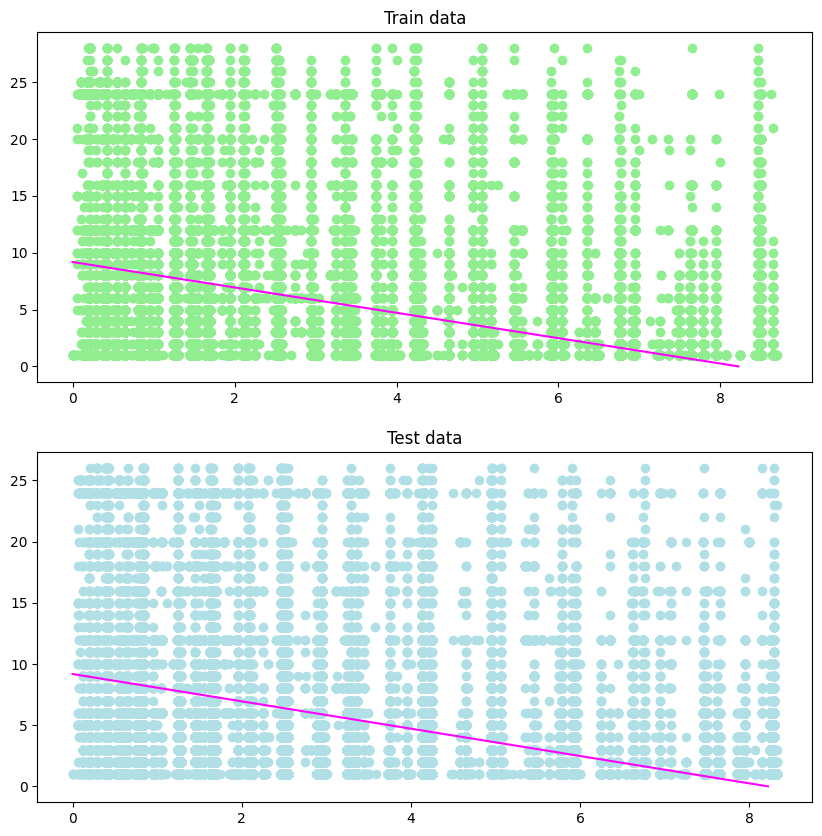

In [125]:
fig, ax = plt.subplots(2, figsize=(10, 10))
ax[0].scatter(X_train, y_train, color = 'lightgreen')
ax[0].set_title('Train data')
ax[0].plot([0, -b/k], [b, 0], color = 'magenta')
ax[1].scatter(X_test, y_test, color = 'powderblue')
ax[1].set_title('Test data')
ax[1].plot([0, -b/k], [b, 0], color = 'magenta')
fig.show()

Нашли с помощью метода наименьших квадратов линейную функцию $y = kx + b$, приближающую неизвестную зависимость. У прямой отрицательный наклон, так как ближе к нижнему левому углу плотность расположения точек выше, чем в другой части графика. Из этого делаем вывод, что данная функция от цены товаров может использоваться для прогноза количества их продаж\
Теперь попробуем приблизить, используя не линейную функцию, а гиперболическую

In [126]:
import numpy.linalg as lg
from numpy.linalg import inv


deg_x = np.vstack([X_train ** (-1)]).T
koeff_b = np.dot(np.dot(lg.inv(np.dot(deg_x.T, deg_x)), deg_x.T), y_train)
ans = "y = "
ans+=str(koeff_b[0])
ans+=" * x^(-1)"
print(ans, sep=' ')

y = 0.1758339582548073 * x^(-1)


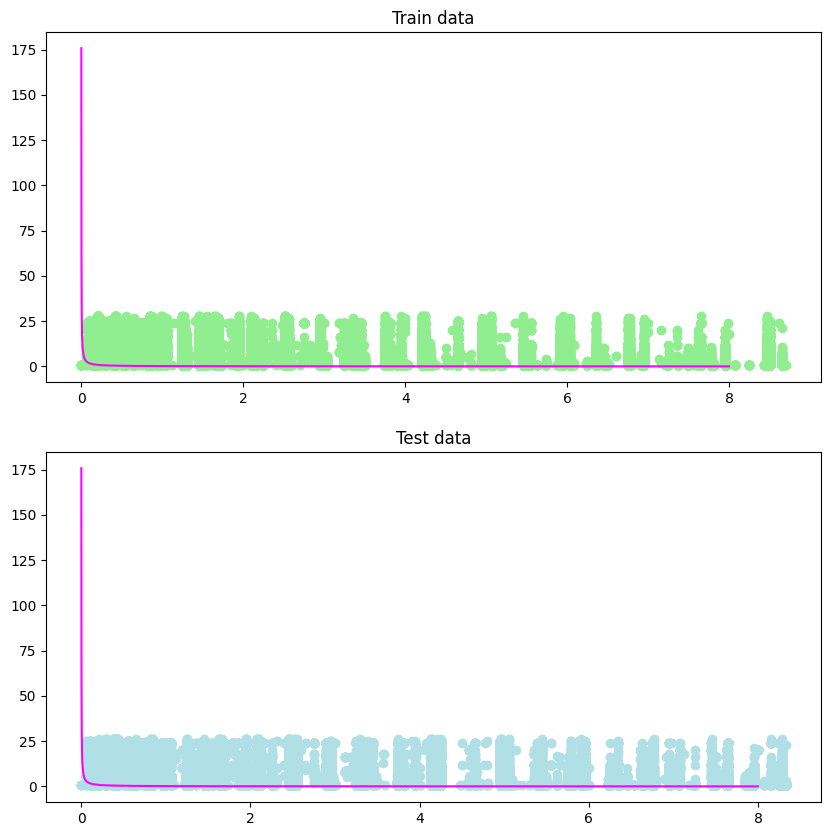

In [127]:
rang = []
for j in range(1,8000):
  rang.append(j/1000)
y = [1/i * koeff_b for i in rang]
fig, ax = plt.subplots(2, figsize=(10, 10))
ax[0].scatter(X_train, y_train, color = 'lightgreen')
ax[0].set_title('Train data')
ax[0].plot([i for i in rang],  y, color = 'magenta')
ax[1].scatter(X_test, y_test, color = 'powderblue')
ax[1].set_title('Test data')
ax[1].plot([i for i in rang],  y, color = 'magenta')
fig.show()


Данная функция проходит ближе к началу координат, где наибольшее скопление точек, что является более точным приближением, чем линейная функция